# Classification du Diagnostic de Performance Énergétique (DPE)

Ce notebook a pour objectif de développer un modèle de **classification supervisée**
permettant de prédire la **classe DPE (A à G)** d’un logement à partir de ses
caractéristiques physiques, énergétiques et techniques.

Ce travail s’inscrit dans le projet **IES**, visant à estimer la performance
énergétique d’un logement avant et après travaux de rénovation.

## Import des bibliothèques

In [2]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay
)

import matplotlib.pyplot as plt
import joblib


## Chargement des données

Les données utilisées sont issues du fichier `DPE.csv`, préalablement nettoyé
et stocké dans le dossier `data/processed`.

In [3]:
df = pd.read_csv("../../data/processed/DPE.csv")
df.head()

,type_batiment,type_installation_chauffage,type_installation_ecs,hauteur_sous_plafond,etiquette_dpe,etiquette_ges,surface_habitable_logement,nombre_niveau_logement,code_postal_ban,qualite_isolation_enveloppe,cout_total_5_usages_energie_n1,conso_5 usages_ef,conso_5_usages_ep,type_energie_principale_chauffage
0,appartement,collectif,collectif,2.5,D,D,32.0,1.0,75013.0,insuffisante,564.9,7643.1,8248.7,Réseau de Chauffage urbain
1,appartement,individuel,individuel,2.5,E,B,74.2,2.0,54160.0,insuffisante,1664.0,9978.0,22949.4,Électricité
2,appartement,individuel,individuel,2.8,D,D,38.6,1.0,75007.0,insuffisante,731.0,7969.2,8350.1,Gaz naturel
3,maison,individuel,individuel,2.3,D,B,57.2,3.0,44390.0,bonne,1027.5,5932.8,13645.4,Électricité
4,appartement,individuel,individuel,2.5,D,B,32.2,1.0,93370.0,insuffisante,674.4,3639.9,8371.7,Électricité


## Exploration rapide du jeu de données

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8787 entries, 0 to 8786
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   type_batiment                      8787 non-null   object 
 1   type_installation_chauffage        8787 non-null   object 
 2   type_installation_ecs              8787 non-null   object 
 3   hauteur_sous_plafond               8787 non-null   float64
 4   etiquette_dpe                      8787 non-null   object 
 5   etiquette_ges                      8787 non-null   object 
 6   surface_habitable_logement         8787 non-null   float64
 7   nombre_niveau_logement             8787 non-null   float64
 8   code_postal_ban                    8787 non-null   float64
 9   qualite_isolation_enveloppe        8787 non-null   object 
 10  cout_total_5_usages_energie_n1     8787 non-null   float64
 11  conso_5 usages_ef                  8787 non-null   float

In [5]:
df["etiquette_dpe"].value_counts().sort_index()


etiquette_dpe
A      80
B     221
C    1873
D    2808
E    2003
F    1022
G     780
Name: count, dtype: int64

## Nettoyage et sélection des variables

- Suppression des lignes sans étiquette DPE
- Exclusion de `etiquette_ges` pour éviter toute fuite de label

In [6]:
df = df.dropna(subset=["etiquette_dpe"])

X = df.drop(columns=["etiquette_dpe", "etiquette_ges"])
y = df["etiquette_dpe"]

## Encodage de la variable cible

Les classes DPE (A à G) sont encodées sous forme numérique afin d’être utilisées
par les algorithmes de classification.


In [7]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

label_encoder.classes_

array(['A', 'B', 'C', 'D', 'E', 'F', 'G'], dtype=object)

## Séparation des données

Un découpage stratifié est utilisé afin de conserver la distribution
des classes DPE dans les ensembles d’entraînement et de test.

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y_encoded,
    test_size=0.2,
    stratify=y_encoded,
    random_state=42
)

## Préprocessing des données

- Variables numériques : standardisation
- Variables catégorielles : One-Hot Encoding

In [9]:
categorical_features = [
    "type_batiment",
    "type_installation_chauffage",
    "type_installation_ecs",
    "qualite_isolation_enveloppe",
    "type_energie_principale_chauffage",
    "code_postal_ban"
]

numerical_features = [
    "hauteur_sous_plafond",
    "surface_habitable_logement",
    "nombre_niveau_logement",
    "cout_total_5_usages_energie_n1",
    "conso_5 usages_ef",
    "conso_5_usages_ep"
]

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numerical_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
    ]
)

## Modèle de classification

Un modèle de type **Random Forest** est utilisé afin de capturer des relations
non linéaires entre les variables explicatives et la classe DPE.

In [10]:
model = RandomForestClassifier(
    n_estimators=300,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)

## Pipeline de classification

Le pipeline combine le preprocessing et le modèle dans une seule chaîne
réutilisable et déployable.

In [11]:
pipeline = Pipeline(steps=[
    ("preprocessing", preprocessor),
    ("classifier", model)
])

## Entraînement du modèle

In [13]:
pipeline.fit(X_train, y_train)

,steps,"[('preprocessing', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


## Évaluation des performances


In [14]:
y_pred = pipeline.predict(X_test)

print(
    classification_report(
        y_test,
        y_pred,
        target_names=label_encoder.classes_
    )
)

              precision    recall  f1-score   support

           A       0.50      0.19      0.27        16
           B       0.73      0.25      0.37        44
           C       0.79      0.73      0.76       375
           D       0.69      0.86      0.77       562
           E       0.64      0.66      0.65       401
           F       0.60      0.43      0.50       204
           G       0.81      0.69      0.74       156

    accuracy                           0.70      1758
   macro avg       0.68      0.54      0.58      1758
weighted avg       0.70      0.70      0.69      1758



## Matrice de confusion

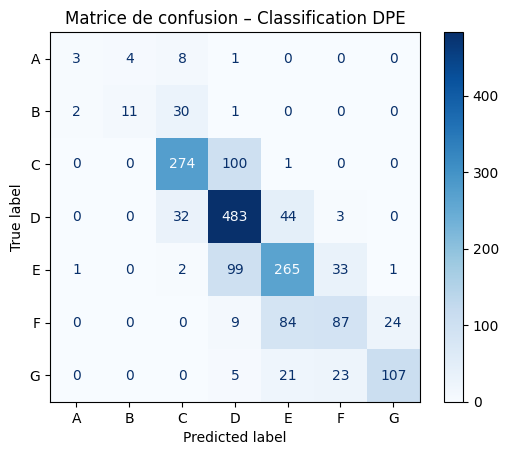

In [15]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=label_encoder.classes_
)

disp.plot(cmap="Blues")
plt.title("Matrice de confusion – Classification DPE")
plt.show()


## Validation croisée

La validation croisée permet d’évaluer la robustesse du modèle.

In [17]:
cv_scores = cross_val_score(
    pipeline,
    X_train,
    y_train,
    cv=5,
    scoring="f1_macro"
)

cv_scores.mean(), cv_scores.std()

print("Moyenne : ", cv_scores.mean())
print("Écart type : ", cv_scores.std())

Moyenne :  0.5875040630425786
Écart type :  0.024177676984216627


## Sauvegarde du pipeline

Le pipeline final est sauvegardé pour être réutilisé dans l’interface utilisateur
ou un backend d’inférence.

In [ ]:
# joblib.dump(pipeline, "../models/dpe_classifier.joblib")
# joblib.dump(label_encoder, "../models/dpe_label_encoder.joblib")